In [102]:
from typing import Optional, Iterable

import pandas as pd
import numpy as np

from time_series_anomaly_detection.abstractions import (
    TimeSeriesAnomalyDetector
)

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import glorot_normal # this is xavier initializer as described in the paper
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
from tensorflow.keras.optimizers import Adam,RMSprop

import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [103]:
class MultipleTimeseriesGenerator(Sequence):    
    def __init__(self, df_list, anomaly_list=None, time_window=8, shuffle=False, batch_size=32):
        super().__init__()
        # drop remainder (batch with len < batch_size)
        df_list = [np.array(series)[:(len(series)-len(series)%batch_size)] for series in df_list]
        
        if anomaly_list is None:
            self.anomaly_list = [np.zeros(len(series)) for series in df_list]
        else:
            self.anomaly_list = anomaly_list
            
        self.batch_size = batch_size
        self.generators = [TimeseriesGenerator(np.array(df_list[i]),np.array(self.anomaly_list[i]),length=time_window, 
                                               batch_size=batch_size, shuffle=shuffle) for i in range(len(df_list))]
        
        self.generator_lengths = [len(g) for g in self.generators]
        self.generator_indexes = np.cumsum(self.generator_lengths)
        self.len = np.sum(self.generator_lengths)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        # which series contains this index
        time_series_index = np.where(self.generator_indexes>index)[0][0]
        
        # get generator for the series, calculate position within than series and get its element
        element = self.generators[time_series_index][index % self.generator_indexes[max(0,time_series_index-1)]]
        return element
    
class CustomFunctionCallback(tf.keras.callbacks.Callback):
    def __init__(self, fun, epoch_frequency=50):
        self.fun = fun
        self.epoch_frequency = epoch_frequency
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_frequency == 0:
            print(f"Epoch {epoch}")
            self.fun()

class SCVAEDetector(TimeSeriesAnomalyDetector):
    """
    Anomaly detector implemented as described in https://arxiv.org/pdf/1712.06343.pdf

    Parameters
    ----------
    id_columns: Iterable[str], optional
        ID columns used to identify individual time series.

        Should be specified in case the detector is provided with
        time series during training or inference with ID columns
        included. Using these columns the detector can separate individual
        time series and not use ID columns as feature columns.
        In case they are not specified, all columns are regarded as feature
        columns and the provided data is regarded as a single time series.
    """

    def __init__(
        self,
        latent_dim: Optional[int] = 5,
        time_window: Optional[int] = 8,
        batch_size: Optional[int] = 8,
        id_columns: Optional[Iterable[str]] = None,
        use_probability_reconstruction: Optional[bool] = False
    ):
        super().__init__()
        self._latent_dim = latent_dim
        self._time_window = time_window
        self._id_columns = id_columns if id_columns is not None else []
        self._batch_size = batch_size
        self._real_samples = None  
        self._mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
        self._scaler = StandardScaler()
        self._use_probability_reconstruction = use_probability_reconstruction
        
    def _split_multiple_timeseries_by_id(self, df_series) -> Iterable[pd.DataFrame]:
        if self._id_columns == []:
            return [df_series]
        
        return [pd.DataFrame(y).drop(self._id_columns,axis=1)
                for x, y in df_series.groupby(self._id_columns, as_index=False)]

    def predict_anomaly_scores(
        self, X: pd.DataFrame, *args, **kwargs
    ) -> pd.Series:
        time_windows = list(pd.DataFrame(scvae._scaler.transform(X)).rolling(self._time_window))
        if self._use_probability_reconstruction:
            return pd.Series([self._reconstruction_probability(window) for window in time_windows])
        else:
            return pd.Series([self._reconstruction_score_mse(window) for window in time_windows])

    def _scale_columns(self, X: pd.DataFrame):
        for i in range(len(X)):
            X[i][X[i].columns] = self._scaler.transform(X[i][X[i].columns])
        return X
        
    def plot_real_vs_generated(self):
        if self._real_samples is None:
            self._real_samples = self._timeseries_generator[0][0] # pick element, pick only timeseries  
        res = self._model(self._real_samples)
        output = res[0]
        fig, axs = plt.subplots(2, 5, figsize=(15,10))
        input, output = tf.split(output, num_or_size_splits=2, axis=0)
        for i in range(5):
            axs[0,i].plot(self._real_samples[i])
            axs[1,i].plot(output[i])            
        plt.show()
        
    def _reparametrization_latent(self, args):
        mean, logvar = args
        # Adding Gaussian noise, avoiding backpropagation path
        eps = tf.random.normal(shape = (self._batch_size, self._latent_dim))
        return eps * tf.exp(logvar * 0.5) + mean
    
    def _reparametrization_series(self, args):
        mean, logvar = args
        eps = tf.random.normal(shape = (self._batch_size, self._time_window * self._feature_count))
        return eps * tf.exp(logvar * 0.5) + mean
    
    def _kl_loss(self, y_true, y_pred):
        mean, logvar = tf.split(y_pred, num_or_size_splits=2, axis=0)
        loss = -0.5*tf.keras.backend.sum(1 + logvar - mean**2 - tf.exp(logvar),axis=-1)
        return loss
    
    def _reconstruction_loss(self, y_true, y_pred):
        input, output = tf.split(y_pred, num_or_size_splits=2, axis=0)
        return self._mse(input, output)

    
    def _build_encoder(self):
    # Encoder
        input = Input(shape=(self._time_window,self._feature_count),batch_size=self._batch_size)
        # Squeeze convolution
        x = Conv1D(16, kernel_size=1, strides=1, kernel_initializer=glorot_normal, padding='same')(input)
        x = Activation('relu')(x)
        x = BatchNormalization(momentum=0.9)(x)

        # Extend (expand) convolutions
        extend1 = Conv1D(16, kernel_size=1, strides=1, kernel_initializer=glorot_normal, padding='same')(x)
        extend1 = Activation('relu')(extend1)
        extend1 = BatchNormalization(momentum=0.9)(extend1)
        extend2 = Conv1D(32, kernel_size=3, strides=1, kernel_initializer=glorot_normal, padding='same')(x)
        extend2 = Activation('relu')(extend2)
        extend2 = BatchNormalization(momentum=0.9)(extend2)
        x = Concatenate()([extend1, extend2])
    
        # Fully connected layers    
        x = Flatten()(x)
        mean = Dense(self._latent_dim)(x)
        logvar = Dense(self._latent_dim)(x)
        return Model(name='scvae_encoder',inputs=input, outputs=[mean, logvar])     
        
    def _build_decoder(self):
    # Encoder
        input = Input(shape=(self._latent_dim,1),batch_size=self._batch_size)
        
         # Squeeze convolution
        x = Conv1DTranspose(16, kernel_size=1, strides=1, kernel_initializer=glorot_normal, padding='same')(input)
        x = Activation('relu')(x)
        x = BatchNormalization(momentum=0.9)(x)
        
        # Extend (expand) convolutions
        extend1 = Conv1DTranspose(16, kernel_size=1, strides=1, kernel_initializer=glorot_normal, padding='same')(x)
        extend1 = Activation('relu')(extend1)
        extend1 = BatchNormalization(momentum=0.9)(extend1)
        extend2 = Conv1DTranspose(1, kernel_size=3, strides=1, kernel_initializer=glorot_normal, padding='same')(x)
        extend2 = Activation('relu')(extend2) 
        extend2 = BatchNormalization(momentum=0.9)(extend2)        
        
        x = Concatenate()([extend1, extend2])        
        
        x = Flatten()(x)
        # Fully connected layers    
        mean = Dense(self._time_window * self._feature_count)(x)
        logvar = Dense(self._time_window * self._feature_count)(x)
        return Model(name='scvae_decoder',inputs=input, outputs=[mean, logvar])
        
    def _build_model(self):        
        encoder = self._build_encoder()
        decoder = self._build_decoder()
        
        input = Input(shape=(self._time_window,self._feature_count),batch_size=self._batch_size)
        mean_encoder, logvar_encoder = encoder(input)  
        
        # "Sampling" using reparametrization trick        
        x = Lambda(self._reparametrization_latent, output_shape=(self._latent_dim,))([mean_encoder, logvar_encoder])
        x = Reshape((self._latent_dim,1))(x)
        mean_decoder, logvar_decoder = decoder(x)  
        
        # "Sampling" using reparametrization trick        
        x = Lambda(self._reparametrization_series, output_shape=(self._time_window * self._feature_count,1))([mean_decoder, logvar_decoder])                
        output = Reshape((self._time_window, self._feature_count,))(x)
        out_reconstruction = Concatenate(axis=0,name='reconstruction')([input,output])
        out_encoder = Concatenate(axis=0,name='encoder_kl')([mean_encoder,logvar_encoder])
        out_decoder = Concatenate(axis=0,name='decoder_kl')([mean_decoder,logvar_decoder])
        model =  Model(inputs=input, outputs=[out_reconstruction,out_encoder,out_decoder])
        return model
    
    def _init_empty_model(self, X: pd.DataFrame) -> None:
        self._feature_count = len(X.columns) - len(self._id_columns)    
        self._model = self._build_model() 
    
    def fit(self, X: pd.DataFrame, learning_rate: float = 0.0005, *args, **kwargs) -> None:
        self._feature_count = len(X.columns) - len(self._id_columns)
        X = self._split_multiple_timeseries_by_id(X)        
        self._scaler.fit(pd.concat(X))
        X = self._scale_columns(X)       
        self._model = self._build_model()    
        self._timeseries_generator = MultipleTimeseriesGenerator(X, batch_size=self._batch_size, time_window=self._time_window, shuffle=True)
        
        losses = {
            "reconstruction": self._reconstruction_loss,
            "encoder_kl": self._kl_loss,
            "decoder_kl": self._kl_loss
        }
        
        def reconstruct():
            print(self._reconstruction_probability(X[0][:self._time_window],debug_plots=True))
                                              
        callbacks = [
            # enables tracking losses in tensorboard
            tf.keras.callbacks.TensorBoard(log_dir=f'./logs'),
            
            # show subplots with real and reconstructed samples to visually compare them
            CustomFunctionCallback(self.plot_real_vs_generated, epoch_frequency=1000)
             
            # shows several reconstructions and calculates reconstruction probability for one sample
            # CustomFunctionCallback(reconstruct)
        ]
        self._model.compile(loss=losses, optimizer=RMSprop(learning_rate=learning_rate))
        self._model.fit(self._timeseries_generator, epochs=20000, verbose=0, callbacks=callbacks)
        
    # https://github.com/Michedev/VAE_anomaly_detection/blob/master/VAE.py
    def _reconstruction_probability(self, X: pd.DataFrame, debug_plots=False):
        if np.array(X).shape != (self._time_window, self._feature_count) or X.isnull().values.any():
            return np.nan
        L = 100
        mean_latent, logvar_latent = self._model.get_layer('scvae_encoder')(tf.reshape(X,(1,X.shape[0],X.shape[1])))
        mean_latent = tf.reshape(mean_latent,shape = [-1]) # flatten to vector
        logvar_latent = tf.reshape(logvar_latent,shape = [-1]) 
        latent_distribution = multivariate_normal.rvs(mean=mean_latent, cov=np.diag(np.exp(logvar_latent)), size=L) # logvar vector -> diagonal covariance matrix
        latent_distribution = tf.reshape(latent_distribution,(L,self._latent_dim,1))
        mean_series, logvar_series = self._model.get_layer('scvae_decoder')(latent_distribution)
        # debug lines for what is the visual generated recosntruction
        if debug_plots:
            print("Real sample")
            plt.plot(X)
            plt.show()
            reconstructing_distributions = [multivariate_normal.rvs(mean=tf.reshape(mean,shape=[-1]), cov=np.diag(np.exp(tf.reshape(logvar,shape=[-1]))),size=3) for mean,logvar in zip(mean_series,logvar_series)]
            print("Sampled from network output")
            for i in range(3):
                plt.plot(np.reshape(reconstructing_distributions[i][0],(X.shape[0],X.shape[1])))
                plt.show()
        probabilities = [multivariate_normal.pdf(tf.reshape(X,shape=[-1]), mean=tf.reshape(mean,shape=[-1]), cov=np.diag(np.exp(tf.reshape(logvar,shape=[-1])))) for mean,logvar in zip(mean_series,logvar_series)]
        return np.mean(probabilities)
        
    def _reconstruction_score_mse(self, X: pd.DataFrame, debug_plots=False):
        if np.array(X).shape != (self._time_window, self._feature_count) or X.isnull().values.any():
            return np.nan
        L = 10
        mean_latent, logvar_latent = self._model.get_layer('scvae_encoder')(tf.reshape(X,(1,X.shape[0],X.shape[1])))
        mean_latent = tf.reshape(mean_latent,shape = [-1]) # flatten to vector
        logvar_latent = tf.reshape(logvar_latent,shape = [-1]) 
        latent_sampled = multivariate_normal.rvs(mean=mean_latent, cov=np.diag(np.exp(logvar_latent)), size=L) # logvar vector -> diagonal covariance matrix for independent vars
        latent_sampled = tf.reshape(latent_sampled,(L,self._latent_dim,1))
        mean_series, logvar_series = self._model.get_layer('scvae_decoder')(latent_sampled)
        series_sampled = [multivariate_normal.rvs(mean=cur_mean, cov=np.diag(np.exp(cur_logvar)), size=L) for cur_mean, cur_logvar in zip(mean_series, logvar_series)]
        # debug lines for what is the visual generated reconstruction
        if debug_plots:
            print("Real sample")
            plt.plot(X)
            plt.show()
            print("Sampled from network output")
            for i in range(3):
                plt.plot(np.reshape(series_sampled[i],(X.shape[0],X.shape[1])))
                plt.show()
        error_scores = [ [self._mse(X, np.reshape(reconstruction,(X.shape[0],X.shape[1]))) for reconstruction in case] for case in series_sampled]
        return np.mean(error_scores)

## Experiments with SKAB dataset

Let's split ```anomaly-free.csv``` dataset into two parts. Use the train part as a 'no anomaly' baseline meant for the network to learn what the processes look like in a stable system. 

Then we will take the testing part and try to see the network's opinion.

Even though the dataset is supposed to be anomaly free, when something not seen during training happens, we are still likely to detect some highly anomalous time windows.

In [104]:
def load_skab_no_anomalies():
    df = pd.read_csv(f'../datasets/skab/anomaly-free/anomaly-free.csv',sep=';').drop(columns=['datetime'])  
    id_cols = ['id_1']    
    return df, None

In [105]:
data,ids = load_skab_no_anomalies()

In [106]:
split_point = int(len(data)*0.75)
train_data = data.iloc[:split_point,:].copy()
test_data = data.iloc[split_point:,:].copy()

## MSE anomaly score

In [ ]:
scvae = SCVAEDetector(latent_dim=16,time_window=8,batch_size=64,id_columns=ids)
scvae._init_empty_model(data)
scvae._scaler = StandardScaler()
scvae._scaler.fit(train_data)
scvae._model.load_weights("5000epochs_no_anomalies_train")
test_res = scvae.predict_anomaly_scores(test_data)

### Train data

Low expected anomaly score overall, train data is supposed to be normal, with no anomalies. The network should know how to reconstruct this data most of the time.

(-3.0, 3.0)

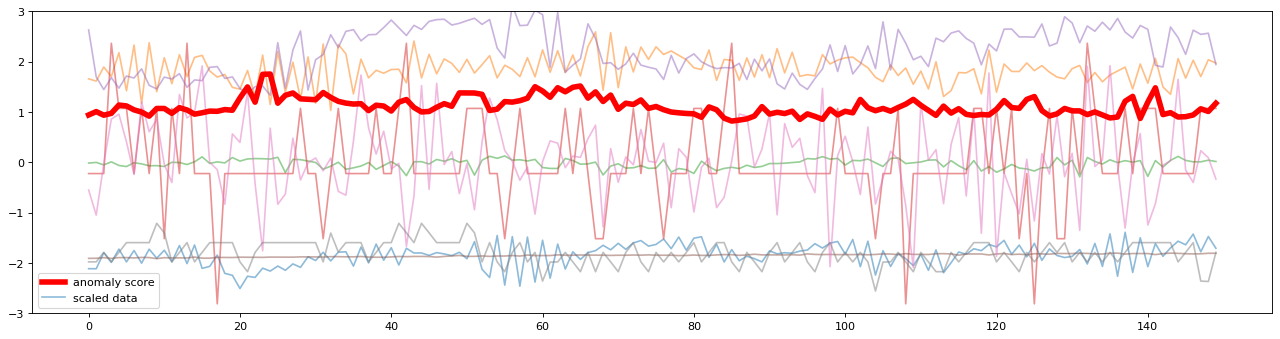

In [101]:
plt.figure(figsize=(20, 5), dpi=80)
plt.plot(scvae._scaler.transform(train_data[200:350]), alpha=0.5, label='scaled data')
plt.plot(np.array(train_res[200:350]), lw=5, c='red', label='anomaly score')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels)
plt.ylim(-3,3)

## Test data

Higher average anomaly score expected than train data.

In case some of particular events ocurring that were not seen often in training data, we should see spikes in anomaly score.

(-3.0, 3.0)

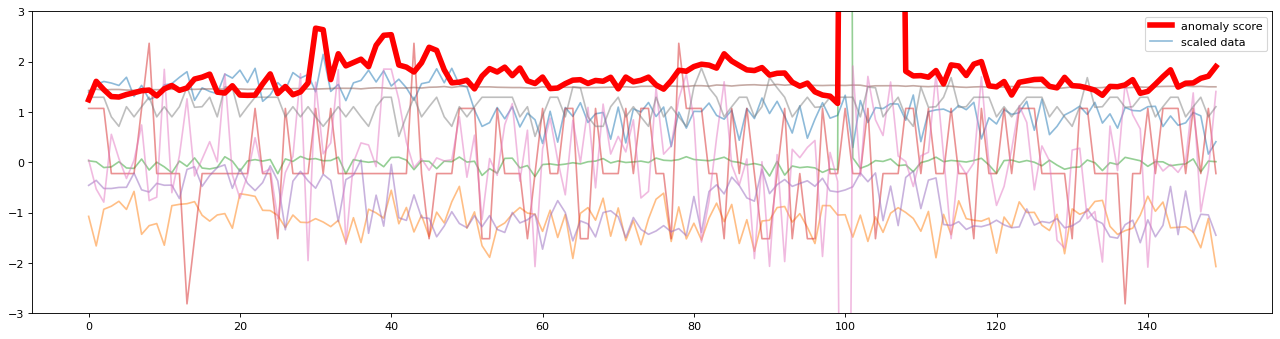

In [100]:
plt.figure(figsize=(20, 5), dpi=80)
plt.plot(scvae._scaler.transform(test_data[200:350]), alpha=0.5, label='scaled data')
plt.plot(np.array(test_res[200:350]), lw=5, c='red', label='anomaly score')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels)
plt.ylim(-3,3)

## Probability anomaly score

Please note the ```use_probability_reconstruction``` parameter in object creation.

In [108]:
scvae = SCVAEDetector(latent_dim=16,time_window=8,batch_size=64,id_columns=ids, use_probability_reconstruction=True)
scvae._init_empty_model(data)
scvae._scaler = StandardScaler()
scvae._scaler.fit(train_data)
scvae._model.load_weights("5000epochs_no_anomalies_train")
train_res = scvae.predict_anomaly_scores(train_data)
test_res = scvae.predict_anomaly_scores(test_data)

Reconstruction score implemented as described in the paper, but very unstable, reporting significant anomalies even in training data.

It's not a true probability anyway (it's a probability density), and there are some ambiguities even in the paper introducing the concept of using VAE to obtain reconstruction probability (see https://stats.stackexchange.com/questions/427597/obtaining-vae-reconstruction-probability)

SCVAE paper states that $\text{Anomaly score} = 1 - \text{Reconstruction probability}$, but using a probability density leads to values outside of 0-1 range.

(-3.0, 3.0)

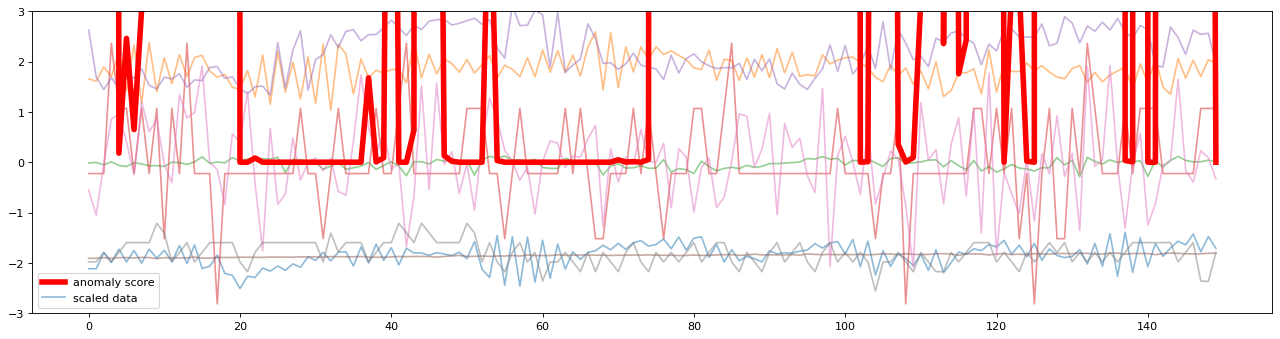

In [109]:
plt.figure(figsize=(20, 5), dpi=80)
plt.plot(scvae._scaler.transform(train_data[200:350]), alpha=0.5, label='scaled data')
plt.plot(np.array(train_res[200:350]), lw=5, c='red', label='anomaly score')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels)
plt.ylim(-3,3)

(-3.0, 3.0)

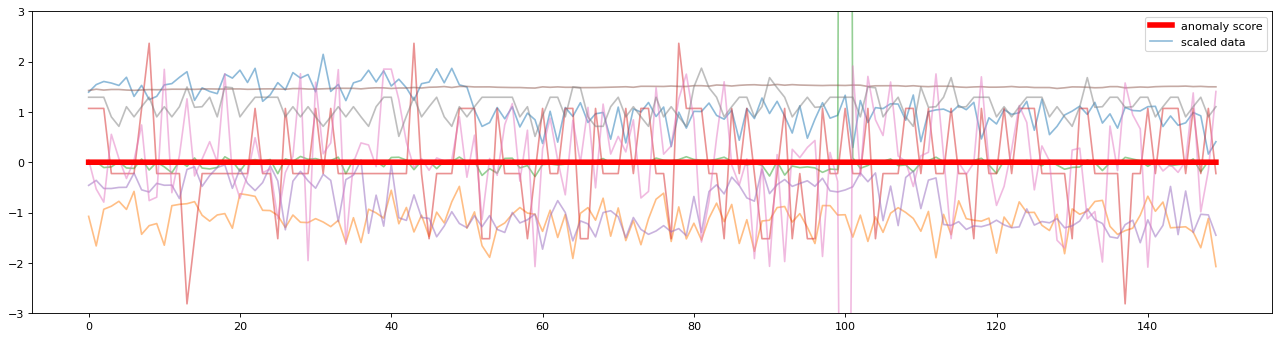

In [110]:
plt.figure(figsize=(20, 5), dpi=80)
plt.plot(scvae._scaler.transform(test_data[200:350]), alpha=0.5, label='scaled data')
plt.plot(np.array(test_res[200:350]), lw=5, c='red', label='anomaly score')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels)
plt.ylim(-3,3)